In [1]:
import logging
import asyncio
import uuid
import os
from typing import Annotated, TypedDict, List, Dict, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import gradio as gr
from IPython.display import Image, display
from datetime import datetime
import json

c:\Users\DeepDabhi\Desktop\Projects\travel-track\travel-serp-new\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SmartJSONFormatter(logging.Formatter):
    def format(self, record):
        base = f"{self.formatTime(record)} - {record.name} - {record.levelname}"
        msg = record.msg
        try:
            if isinstance(msg, dict):
                return f"{base} - JSON payload:\n{json.dumps(msg, indent=2, default=str)}"
            if isinstance(msg, str) and msg.strip().startswith(("{", "[")):
                parsed = json.loads(msg)
                return f"{base} - JSON payload:\n{json.dumps(parsed, indent=2, default=str)}"
        except Exception as e:
            logger.warning(f"Failed to serialize log message as JSON: {e}")
        return f"{base} - {record.getMessage()}"


# Configure logging with File + Console
logging.basicConfig(
    level=logging.INFO,
    handlers=[
        logging.FileHandler("clean_6.log"),
        logging.StreamHandler()
    ]
)

# Apply formatter to all handlers
formatter = SmartJSONFormatter()
for handler in logging.getLogger().handlers:
    handler.setFormatter(formatter)

logger = logging.getLogger(__name__)


In [3]:
now = datetime.now()
current_date = now.date()
current_day = now.strftime("%A")
current_year = now.year


In [4]:
# Load environment variables
logger.info("Loading environment variables")
load_dotenv(override=True)

2025-08-25 17:46:25,251 - __main__ - INFO - Loading environment variables


True

In [5]:
# loading APIs
google_api_key = os.getenv("GOOGLE_API_KEY")
if not google_api_key:
    raise ValueError("GOOGLE_API_KEY not found in .env file")

In [6]:
try:
    llm_1 = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)
    llm_2 = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)
    llm_3 = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)
except Exception as e:
    logger.error(f"Failed to initialize LLMs: {str(e)}")
    raise

In [7]:
class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feddback on assistant's response")
    success_criteria_met: bool = Field(description="wether the success criteria have been met or not")
    user_input_needed: bool = Field(description="True if more input is needed from the user, or clarifications, or the assistant is stuck")

In [8]:
class PayloadOutput(BaseModel):
    departure_city: str = Field(description="The departure city")
    arrival_city: str = Field(description="The arrival city")
    outbound_date: str = Field(description="The departure date")
    adults: int = Field(description="Number of adults", default=0)
    children: int = Field(description="Number of children", default=0)
    travel_class: str = Field(description="Travel class: Economy, Premium economy, Business, First.", default="Economy")
    return_date: Optional[str] = Field(description="Return date in format YYYY-MM-DD (e.g., 2025-08-17)", default=None)

In [9]:
FIXED_SUCCESS_CRITERIA = (
    "The assistant must obtain and confirm the following required flight details: departure city, arrival city, departure date, number of adults, number of children."
    "Optional detail for flight booking is return date"
)

In [10]:
class State(BaseModel):
    messages: Annotated[List[Any], add_messages]
    success_criteria: str = FIXED_SUCCESS_CRITERIA
    feedback: Optional[str]
    success_criteria_met: bool
    user_input_needed: bool
    # iteration_count: int
    collected_details: PayloadOutput

In [11]:
worker_llm = llm_1
evaluator_llm = llm_2
evaluator_llm_with_output = evaluator_llm.with_structured_output(EvaluatorOutput)
payload_llm = llm_3.with_structured_output(PayloadOutput)

In [12]:
def worker(state: State) -> Dict[str, Any]:
    logger.info("Entering worker node")
    logger.info(state.model_dump())
    logger.info("Input state messages:")
    logger.info({"messages": [msg.model_dump() for msg in state.messages]})

    system_message = f"""
        You are a helpful travel assistant responsible for collecting flight booking details from the user. Your goal is to gather all required details and prompt for clarifications based on feedback from the evaluator. Follow this structured process:

        Today's date is {current_day}, {current_date}.
        current year is {current_year}.

        1. **Required Fields to Collect** (in this order, unless already provided):
        - Departure city: Name of the city the user is departing from.
        - Arrival city: Name of the city the user is traveling to.
        - Outbound date: The departure date, to be provided in YYYY-MM-DD format.
        - Number of adults: Number of travelers aged 18+ years.
        - Number of children: Number of travelers below 18 years.
        - Travel class: One of [Economy, Premium Economy, Business, First Class].

        2. **Optional Fields** (ask only after all required fields are provided):
        - Ask: "Would you like to specify a return date or any other preferences?"
        - Only collect return date (in YYYY-MM-DD format) if mentioned.
        - If the user specifies preferences not in [return date], respond: "I'm sorry, but I can only assist with specifying a return date as an optional preference. Please provide the return date if needed, or let me know if you want to proceed."

        3. **Rules for Collecting Fields**:
        - If the user provides ambiguous information (e.g., "next Monday" for date, "me and my family" for travelers), prompt for clarification:
            - For dates: Ask for a specific date in YYYY-MM-DD format, parse it using current_date: {current_date}, current_day: {current_day} and current_year: {current_year} as reference.
            - For travelers: Ask for the age of each individual to determine adults (18+ years) and children (below 18 years).
        - If the user refuses to provide a required field, respond: "I'm sorry, but [field] is required to proceed. Please provide [field]."
        - Do not confirm or summarize the collected details until instructed by the evaluator that all required fields are valid.
        - Do not validate whether departure or arrival cities have airports; this will be handled by an external API.

        4. **Incorporating Feedback**:
        - If feedback is provided from the evaluator, address the specific issues mentioned. For example:
            - If a field is invalid (e.g., date in the past), prompt the user to clarify or correct the specific field.
            - If a field is missing, ask for that field explicitly.
        - Example feedback response: "I noticed the provided departure date was invalid. Could you please provide the date in YYYY-MM-DD format, ensuring it's in the future?"

        5. **Response Format**:
        - If details are missing or need clarification: "Question: [your question]"
        - If a required field is refused: "I'm sorry, but [field] is required to proceed. Please provide [field]."
        - If all required fields are collected and no feedback indicates issues: Wait for evaluator instructions. Do not generate a confirmation message prematurely.
        - If feedback indicates an issue: "Question: [specific clarification based on feedback]"

        6. **Default Response**:
        - If unable to generate a specific response (e.g., unclear feedback or user input), use: "Question: Could you please clarify or confirm the details provided? I need to ensure all information is correct before proceeding."
    """

    if state.feedback:
        logger.info("Incorporating feedback:")
        logger.info(state.feedback)
        system_message += f"""
    Previously you thought you completed the assignment, but your reply was rejected because the success criteria was not met.
    Here is the feedback on why this was rejected:
    {state.feedback}
    With this feedback, please continue the assignment, ensuring that you meet the success criteria or have a question for the user."""
        
    found_system_message = False
    messages = state.messages
    logger.info("Processing messages: ")
    logger.info({"messages": [msg.model_dump() for msg in state.messages]})

    for message in messages:
        if isinstance(message, SystemMessage):
            logger.info("Updating existing system message")
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        logger.info("Adding new system message")
        messages = [SystemMessage(content=system_message)] + messages
    
    logger.info("Messages after system message handling: ")
    logger.info({"messages": [msg.model_dump() for msg in messages]}) 

    logger.info("Invoking worker LLM")
    response = worker_llm.invoke(messages)
    
    logger.info("Worker LLM response:")
    logger.info(str(response))
    
    logger.info("Adding worker response to state messages")
    new_state = {
        "messages": [response]
    }
    
    logger.info("Output state messages: ")
    logger.info({"messages": [msg.model_dump() for msg in new_state['messages']]})
    
    return new_state

In [13]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[No content]"
            conversation += f"Assistant: {text}\n"
        elif isinstance(message, SystemMessage):
            conversation += f"System: {message.content}\n"
    return conversation

In [14]:
def evaluator(state: State) -> State:
    logger.info(f"\nEntering evaluator node")
    logger.info(state)
    last_response = state.messages[-1].content
    logger.info(f"Evaluating last response:")
    logger.info({last_response})
    logger.info(f"Current state messages:")
    logger.info({"messages": [msg.model_dump() for msg in state.messages]})
    
    system_message = f"""
        You are an evaluator responsible for assessing whether the Assistant's last response meets the success criteria and validating the collected flight booking details against specific rules. Your goal is to ensure all required fields are collected and valid (except for airport-specific city validation, which is handled externally) before allowing the process to proceed to payload generation.
        
        Today's date is {current_day}, {current_date}.
        current year is {current_year}.

        1. **Success Criteria**:
        {state.success_criteria}

        2. **Field Validation Rules**:
        - Departure city: Must be a non-empty string representing a city name. Do not validate whether the city has an airport; this is handled by an external API.
        - Arrival city: Must be a non-empty string representing a city name, different from the departure city. Do not validate whether the city has an airport.
        - Outbound date: Must be in YYYY-MM-DD format and represent a future date relative to today ({current_date}). If the user provides an ambiguous date (e.g., "31st August"), parse it using current_date: {current_date}, current_day: {current_day} and current_year: {current_year} as reference. If the date is in the past (e.g., 2024-08-31), mark it as invalid and request clarification (e.g., suggest 2025-08-31).
        - Number of adults: Must be a non-negative integer, determined by explicit age confirmation (18+ years). Do not assume ages based on relationships (e.g., "wife" or "son").
        - Number of children: Must be a non-negative integer, determined by explicit age confirmation (below 18 years).
        - Travel class: Must be one of [Economy, Premium Economy, Business, First Class].
        - Return date: Optional. If provided, must be in YYYY-MM-DD format and after the outbound date.

        3. **Evaluation Process**:
        - Review the conversation history: {format_conversation(state.messages)}
        - Assess the Assistant's last response: {state.messages[-1].content}
        - Check if all required fields (departure city, arrival city, outbound date, number of adults, number of children, travel class) have been collected and are valid according to the rules above.
        - Validate any optional fields (return date) if provided.
        - Update the state's `collected_details` with valid fields and mark them in `validated_fields` (e.g., `validated_fields['departure_city'] = True` if valid).
        - If any field is missing or invalid, provide specific feedback for the worker to address.

        4. **Response Format** (structured as EvaluatorOutput):
        - **feedback**: Detailed explanation of the evaluation, including:
            - Whether the success criteria are met.
            - Specific validation errors for any invalid fields (e.g., "The outbound date '2024-08-31' is in the past. Please confirm a future date.").
            - Instructions for clarification (e.g., "The number of adults is missing. Ask for the ages of travelers.").
        - **success_criteria_met**: Set to `True` only if all required fields are collected and valid.
        - **user_input_needed**: Set to `True` if:
            - The Assistant is asking a question or seeking clarification.
            - Any required field is missing or invalid.
            - The Assistant is stuck or repeating errors from prior feedback.

        5. **Handling Prior Feedback**:
        - If prior feedback exists ({state.feedback}), check if the Assistant is repeating the same mistakes (e.g., failing to clarify an invalid date).
        - If errors persist, emphasize in the feedback that user input is needed to resolve the issue, and provide a clear action for the worker (e.g., "The Assistant is still using an invalid date. Prompt the user to confirm a future date in YYYY-MM-DD format.").

        6. **Example Feedback**:
        - Valid response: "The Assistant has collected all required fields and they are valid (except for airport validation, which is handled externally). The success criteria are met."
        - Invalid date: "The Assistant collected the outbound date as '2024-08-31', which is in the past. The worker should ask the user to confirm a future date, such as '2025-08-31'."
        - Missing field: "The Assistant has not collected the number of adults. The worker should ask for the ages of travelers to determine adults and children."
    """
    
    user_message = f"""You are evaluating a conversation between the User and Assistant. You decide what action to take based on the last response from the Assistant.

    The entire conversation with the assistant, with the original request of the user and all replies, are:
    {format_conversation(state.messages)}

    The success criteria for this assignment is:
    {state.success_criteria}

    And the final response from the Assistant that you are evaluating is:
    {last_response}

    Respond with your feedback, and decide if the success criteria is met by this response.
    Also, decide if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and unable to answer without help.
    """
    if state.feedback:
        logger.info("Adding previous feedback to evaluation:")
        logger.info(state.feedback)
        user_message += f"Also, note that in a prior attempt from the Assistant, you provided this feedback: {state.feedback}\n"
        user_message += "If you are seeing the Assistant repeating the same mistakes, then consider responding that user input is required."
    
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]
    logger.info("Evaluator input messages:")
    logger.info({"messages": [msg.model_dump() for msg in state.messages]})
    
    logger.info("Invoking evaluator LLM")
    eval_result = evaluator_llm_with_output.invoke(evaluator_messages)
    logger.info(f"Evaluator result: feedback={eval_result.feedback}, success_criteria_met={eval_result.success_criteria_met}, user_input_needed={eval_result.user_input_needed}")
    
    new_state = State(
        messages=[AIMessage(content=f"Evaluator Feedback on this answer: {eval_result.feedback}")],
        success_criteria=state.success_criteria,
        feedback=eval_result.feedback,
        success_criteria_met=eval_result.success_criteria_met,
        user_input_needed=eval_result.user_input_needed,
        collected_details=state.collected_details
    )
    
    logger.info("Adding evaluator feedback to state messages")
    logger.info(f"New state: ")
    logger.info(new_state.model_dump())
    return new_state

In [15]:
def create_payload(state: State) -> Dict[str, Any]:
    logger.info("Entering payload generator node")
    logger.info({"state": state.model_dump()})
    
    # Extract the latest assistant message
    messages = state.messages
    latest_message = None
    for message in reversed(messages):
        if isinstance(message, AIMessage):
            latest_message = message.content
            break
    
    if not latest_message:
        logger.error("No assistant message found in state")
        return {
            "messages": [AIMessage(content="Error: Unable to generate payload due to missing assistant response.")],
            "user_input_needed": True
        }
    
    logger.info(f"Processing latest assistant message: {latest_message}")
    
    # Check if the message indicates all required details are collected
    # if "Here are the flight details" in latest_message:
    try:
        # Invoke payload_llm to generate structured output
        logger.info("Invoking payload LLM")
        payload = payload_llm.invoke(messages)
        
        logger.info("Generated payload:")
        logger.info(json.dumps(payload.model_dump(), indent=2))

        new_state = State(
            messages=[AIMessage(content=f"Payload generated successfully: {json.dumps(payload.model_dump(), indent=2)}")],
            success_criteria=state.success_criteria,
            feedback=state.feedback,
            success_criteria_met=state.success_criteria_met,
            user_input_needed=False,
            collected_details=payload  # Update this field
        )
        logger.info(new_state.model_dump())
        return new_state
    except Exception as e:
        logger.error(f"Error generating payload: {str(e)}")
        return {
            "messages": [AIMessage(content="Sorry, I encountered an error while generating the booking details. Could you please confirm the details again?")],
            "success_criteria_met": False,
            "user_input_needed": True
        }

In [16]:
def list_flights(state: State) -> State:
    print(state.collected_details)
    return state

In [17]:
def getAirports(location):
    return "TIR"

In [18]:
def getAirports(location):
    return "TIR"

In [19]:
def route_based_on_evaluation(state: State) -> str:
    if state.success_criteria_met:
        return "create_payload"
    if state.user_input_needed:
        return END
    logger.info("Routing to worker: Continuing extraction")
    return "worker"

In [20]:
logger.info("Setting up LangGraph")
graph_builder = StateGraph(State)

# Add nodes
logger.info("Adding nodes to graph")
graph_builder.add_node("worker", worker)
graph_builder.add_node("evaluator", evaluator)
graph_builder.add_node("create_payload", create_payload)
graph_builder.add_node("list_flights", list_flights)

# Add edges
logger.info("Adding edges to graph")
graph_builder.add_edge("worker", "evaluator")
graph_builder.add_edge("create_payload", "list_flights")
graph_builder.add_edge("list_flights", END)
graph_builder.add_conditional_edges("evaluator", route_based_on_evaluation, {"create_payload": "create_payload", "worker": "worker", END: END})
graph_builder.add_edge(START, "worker")

# Compile the graph
logger.info("Compiling LangGraph with memory")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

2025-08-25 17:46:26,499 - __main__ - INFO - Setting up LangGraph
2025-08-25 17:46:26,504 - __main__ - INFO - Adding nodes to graph
2025-08-25 17:46:26,510 - __main__ - INFO - Adding edges to graph
2025-08-25 17:46:26,513 - __main__ - INFO - Compiling LangGraph with memory


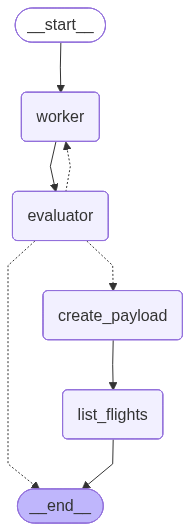

In [21]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    logger.warning(f"Failed to display graph: {str(e)}")

In [22]:
def make_thread_id() -> str:
    thread_id = str(uuid.uuid4())
    logger.info(f"Generated new thread ID: {thread_id}")
    return thread_id

async def process_message(message, history, thread):
    logger.info(f"Processing new user message: {message}")
    
    config = {"configurable": {"thread_id": thread}}
    
    state = State(
        messages=[HumanMessage(content=message)],
        success_criteria=FIXED_SUCCESS_CRITERIA,
        feedback=None,
        success_criteria_met=False,
        user_input_needed=False,
        collected_details = PayloadOutput(
            departure_city="",
            arrival_city="",
            outbound_date="",
            travel_class="Economy",
            adults=0,
            children=0,
            return_date=None
        )
    )
    logger.info("Initial state created")
    logger.info(f"Initial state messages: ")
    logger.info({"messages": [msg.model_dump() for msg in state.messages]})    

    logger.info("Invoking graph with initial state")
    result = await graph.ainvoke(state, config=config)
    logger.info("Graph invocation completed")
    logger.info(f"Graph result messages: ")
    logger.info({"messages": [msg.model_dump() for msg in result["messages"]]})
    
    assistant_response = ""
    evaluator_feedback = ""
    for msg in reversed(result["messages"]):
        if isinstance(msg, AIMessage):
            if "Evaluator Feedback" in msg.content:
                evaluator_feedback = msg.content
            elif "Payload generated successfully" not in msg.content:
                assistant_response = msg.content
                break

    user = {"role": "user", "content": message}
    # reply = {"role": "assistant", "content": result["messages"][-2].content}
    # feedback = {"role": "assistant", "content": result["messages"][-1].content}
    reply = {"role": "assistant", "content": assistant_response}
    feedback = {"role": "assistant", "content": evaluator_feedback}
    
    logger.info("Preparing response for Gradio UI")
    logger.info(f"User message:")
    logger.info(user)
    logger.info(f"Assistant reply: ")
    logger.info(reply)
    logger.info(f"Evaluator feedback:")
    logger.info(feedback)
    
    logger.info("Message processing completed")
    return history + [user, reply, feedback]

In [23]:
async def reset():
    logger.info("Resetting application state")
    return "", None, make_thread_id()

In [24]:
logger.info("Launching Gradio UI")
with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Sidekick Personal Co-worker")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        # chatbot = current state of the chatbot component (conversation history)
        chatbot = gr.Chatbot(label="Travel Chatbot", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to your sidekick")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    
    logger.info("Setting up Gradio event handlers")
    message.submit(process_message, [message, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, chatbot, thread])

2025-08-25 17:46:30,176 - __main__ - INFO - Launching Gradio UI
2025-08-25 17:46:30,778 - __main__ - INFO - Generated new thread ID: d441382e-d2d7-4f2d-8a72-9ecc107f4262
2025-08-25 17:46:30,802 - __main__ - INFO - Setting up Gradio event handlers


2025-08-25 17:46:35,240 - httpx - INFO - HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


In [ ]:
demo.launch()

* Running on local URL:  http://127.0.0.1:7860


2025-08-25 17:46:36,731 - httpx - INFO - HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"
2025-08-25 17:46:36,879 - httpx - INFO - HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"


* To create a public link, set `share=True` in `launch()`.


2025-08-25 17:47:28,369 - __main__ - INFO - Processing new user message: i am going to ahmedabad to pune on 31st augutst 2025, with 2 adult and 2 minors

minor ages: 8 yo and one is 2 yo , i will prefer travelling in economy with no return date decided
2025-08-25 17:47:28,375 - __main__ - INFO - Initial state created
2025-08-25 17:47:28,379 - __main__ - INFO - Initial state messages: 
2025-08-25 17:47:28,385 - __main__ - INFO - JSON payload:
{
  "messages": [
    {
      "content": "i am going to ahmedabad to pune on 31st augutst 2025, with 2 adult and 2 minors\n\nminor ages: 8 yo and one is 2 yo , i will prefer travelling in economy with no return date decided",
      "additional_kwargs": {},
      "response_metadata": {},
      "type": "human",
      "name": null,
      "id": null,
      "example": false
    }
  ]
}
2025-08-25 17:47:28,392 - __main__ - INFO - Invoking graph with initial state
2025-08-25 17:47:28,410 - __main__ - INFO - Entering worker node
2025-08-25 17:47:28,440 - _